## 材料試験自動データ処理

### 導入
最初はcsv生データから，必要なデータを読み取り，応力，縦ひずみ平均値と横ひずみ平均値を算出する．

>ここでは，生データのひずみチャンネル配置によらず，コードで数値の[+，-]を用いて，縦ひずみや横ひずみの判定を行った．

In [ ]:
from glob import glob
from google.colab import drive
import csv
import numpy as np
from openpyxl import load_workbook
import matplotlib.pyplot as plt
 
###google driveに接続する．ローカル実行の場合は消してください．
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab_Notebooks/material_test'
###

filenames = glob('*.csv')
print(filenames)
 
#for filename in filenames:
with open('材料試験_H300W_No.1_データリスト.csv',encoding="utf8",errors='ignore') as f:
  f_csv = csv.reader(f)
  next(f_csv)
  data = list(f_csv)
  a = np.array(data)
  load = a[1:,2]
  a = a[1:,:]         #文字列の次から
  x = range(np.shape(a)[0])
  y = len(data) - 1     #行数を数える
  case1 = np.empty([y,8],dtype = float)
 
#########################
for i in x:
  case1[i,0] = a[i,2]  #load
  case1[i,1] = a[i,3]  #disp
  if float(a[int(y/2),4]) > 0 :   #縦ひずみを判定する
    case1[i,2] = a[i,4]       #縦ひずみ1を定義する
    if float(a[int(y/2),5]) > 0 : #縦ひずみを判定する
      case1[i,3] = a[i,5]     #縦ひずみ2を定義する
      case1[i,4] = a[i,6]     #横ひずみ1を定義する
      case1[i,5] = a[i,7]     #横ひずみ2を定義する
    else :
      case1[i,4] = a[i,5]      #横ひずみ1を定義する
      case1[i,5] = a[i,7]    #横ひずみ2を定義する
      case1[i,3] = a[i,6]    #縦ひずみ2を定義する
  if i == y :
    break
  striantate = (case1[:,2]+case1[:,3])/2        #縦ひずみ平均値
  strianyoko = (case1[:,4]+case1[:,5])/2        #横ひずみ平均値
############################
#　エクセルシート（テンプレート）を読み込む
wb = load_workbook("template_mt.xlsx", data_only=True)  #エクセルシートを導入する
wb1 = wb.active           #シートを選択する

#################
 
A = wb1['F9'].value   #断面積を取得する
case1[:,6] = case1[:,0] *1000/ A     #応力の算出
 
#################


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab_Notebooks/material_test
['材料試験_H300W-No1_データリスト.csv', '材料試験_H300W_No.2_データリスト.csv', '材料試験_H300W_No.3_データリスト.csv']
7513.615


### 降伏点の算出方


---


　標準材料試験に対して，ひずみが4000まで，基本降伏点を超えているため，降伏点の算出は：
> ひずみが4000までの最大応力とする．
 
 　引張強度は応力の最大値を取得する．


In [ ]:
sigma_y = 0
i = 0
while striantate[i] < 4000:
  sigma_y= max(sigma_y,case1[i,6])
  i = i+1
sigma_u = max(case1[:,6])
print('降伏点：',sigma_y)
print('引張強度：',sigma_u)

降伏点： 383.06489749053026
引張強度： 507.06043342537953


### 最小二乗法を用いたヤング率の求め
---
　実験の初期ノイズおよび，降伏点付近の塑性化の影響を排除するため，ヤング率の算出範囲は **[0.2$\sigma_y$ - 0.7$\sigma_y$]** となった．</br>
 　最小二乗法を用いて，曲線の傾き$k_1$は以下のように算出された：
\begin{align}
k_1 =\frac{n \sum_{i=1}^{n} x_{i} y_{i}-\sum_{i=1}^{n} x_{i} \sum_{i=1}^{n} y_{i}}{n \sum_{i=1}^{n} x_{i}^{2}-\left(\sum_{i=1}^{n} x_{i}\right)^{2}}
\end{align}
<br>
 　コードで見やすいため，以下のように省略で表記する．
\begin{align}
 k_1 = \frac {na1 - a21\times a22} {nb1 - a21^2}
\end{align}

<br>
   なお，決定係数$R^2$については，残差の二乗和を標本値の平均値 $\overline{y}$からの偏差の二乗和で割ったものを1から引いた値であり,以下のような式で算出した．
\begin{align}
R^{2} \equiv 1-\frac{\sum_{i=1}^{N}\left(y_{i}-f_{i}\right)^{2}}{\sum_{j=1}^{N}\left(y_{j}-\bar{y}\right)^{2}}
\end{align}


In [ ]:
i = 0; a1 = 0; a21 = 0; a22 = 0; k1 = 0; b1 = 0; n=0;pc = 0;
for j in case1[:,6]:
  if j > 0.2*sigma_y and j < 0.7*sigma_y:
    a1 += (striantate[i] * case1[i,6])
    a21 += striantate[i]
    a22 += case1[i,6]
    b1 += striantate[i] ** 2
    pc += strianyoko[i]/striantate[i]
    n += 1
  i = i+1

k1 = (n*a1 - a21*a22)/(n*b1-a21**2)     #yong's modulus
b0 = a22/n - k1*a21/n            #intercept　切片
pc = -pc/n                   #Poisson coefficient ポアソン比
####### R決定係数の求め
i = 0; ssr = 0; sst = 0
ymean = a22/n
for j in case1[:,6]:
  if j > 0.2*sigma_y and j < 0.7*sigma_y:
    ssr += (case1[i,6] - (striantate[i]*k1+b0))**2
    sst += (case1[i,6] - ymean)**2
  i += 1
R2 = 1 - ssr/sst        #R2 Coefficient of determination，決定係数
######
print('ヤング率E = ',k1*10**6)
print('ポアソン比 = ',pc)
print('決定係数R^2 = ',R2)

ヤング率E =  190528.6431270158
ポアソン比 =  0.25305185229786026
決定係数R^2 =  0.9994418019299354


### グラフの出力

---

 matplotlibを用いてグラフの出力

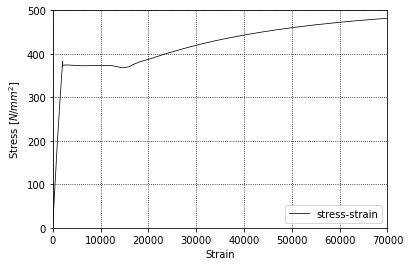

In [ ]:
##############
#グラフを書く
plt.plot(striantate,case1[:,6], label="stress-strain",color='black',linewidth=0.75)
plt.xlabel("Strain")
plt.ylabel("Stress [$N/mm^2$]")
plt.ylim(0, 500)
plt.xlim(0, 70000)
plt.grid(color="k", linestyle=":") # メッシュ背景を点線に設定する
plt.legend(loc=4,numpoints=1)            #凡例
plt.savefig('stress-strain.svg')    #svgとして保存
plt.show()
###############

### データを書き込む
最後に処理完了したデータを全部Excelテンプレートに書き込む．

In [ ]:
wb1.cell(6,10,sigma_y)
wb1.cell(6,11,sigma_u)
wb1.cell(6,12,k1)
wb1.cell(6,13,pc)
for i in range(3,y) :
  for j in range(2,8) :
    wb1.cell(i,j,case1[i-3,j-2]) #シートにi行j列にデータを書き込む
wb.save("111.xlsx")     #保存する

## Full Code

1. フォルダ内に`.csv`ファイルを探して，名前を取得する．
2. 生データを読み取り，データ処理を行う．
3. 生データから，縦ひずみ，横ひずみ平均値と応力を算出する．
4. 降伏点および引張強度を算出する．
5. 最小二乗法を用いてヤング率およびポアソン比の算出．
6. 応力－ひずみ関係グラフを書く，出力，保存する．
7. 計算結果および生データをテンプレートに保存する．

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab_Notebooks/material_test


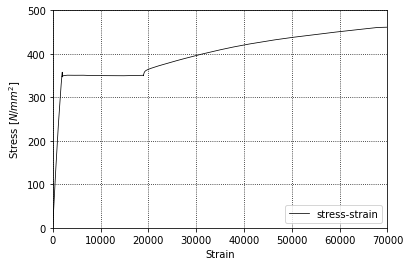

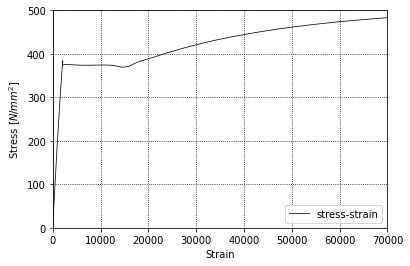

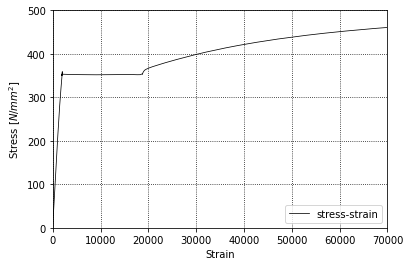

In [ ]:
from glob import glob
from google.colab import drive
import csv
import numpy as np
from openpyxl import load_workbook
import matplotlib.pyplot as plt
 
###
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab_Notebooks/material_test'
filenames = glob('*.csv')
###
m=1;  #生データ書き込むためcellの列数，
row1 = 6  #計算結果を書き込むための行数
############################
#　エクセルシート（テンプレート）を読み込む
wb = load_workbook("template_mt.xlsx", data_only=True)  #エクセルシートを導入する
wb1 = wb.active           #シートを選択する

######
for filename in filenames:
  fname = filename.split('_')[-2]
  with open(filename,encoding="utf8",errors='ignore') as f:
    f_csv = csv.reader(f)
    next(f_csv)
    data = list(f_csv)
    a = np.array(data)
    load = a[1:,2]
    a = a[1:,:]         #文字列の次から
    x = range(np.shape(a)[0])
    y = len(data) - 1     #行数を数える
    case1 = np.empty([y,8],dtype = float)
  
  #########################
  for i in x:
    case1[i,0] = a[i,2]  #load
    case1[i,1] = a[i,3]  #disp
    if float(a[int(y/2),4]) > 0 :   #縦ひずみを判定する
      case1[i,2] = a[i,4]       #縦ひずみ1を定義する
      if float(a[int(y/2),5]) > 0 : #縦ひずみを判定する
        case1[i,3] = a[i,5]     #縦ひずみ2を定義する
        case1[i,4] = a[i,6]     #横ひずみ1を定義する
        case1[i,5] = a[i,7]     #横ひずみ2を定義する
      else :
        case1[i,4] = a[i,5]      #横ひずみ1を定義する
        case1[i,5] = a[i,7]    #横ひずみ2を定義する
        case1[i,3] = a[i,6]    #縦ひずみ2を定義する
    if i == y :
      break
    striantate = (case1[:,2]+case1[:,3])/2        #縦ひずみ平均値
    strianyoko = (case1[:,4]+case1[:,5])/2        #横ひずみ平均値

  #################
  
  A = wb1.cell(row1,6).value   #断面積を取得する
  case1[:,6] = case1[:,0] *1000/ A     #応力の算出
  
  #################降伏点および引張強度の算出
  sigma_y = 0
  i = 0
  while striantate[i] < 4000:
    sigma_y= max(sigma_y,case1[i,6])
    i = i+1
  sigma_u = max(case1[:,6])
  ##############ヤング率の算出
  i = 0; a1 = 0; a21 = 0; a22 = 0; k1 = 0; b1 = 0; n=0;pc = 0;
  for j in case1[:,6]:
    if j > 0.2*sigma_y and j < 0.7*sigma_y:
      a1 += (striantate[i] * case1[i,6])
      a21 += striantate[i]
      a22 += case1[i,6]
      b1 += striantate[i] ** 2
      pc += strianyoko[i]/striantate[i]
      n += 1
    i = i+1

  k1 = (n*a1 - a21*a22)/(n*b1-a21**2)     #yong's modulus
  b0 = a22/n - k1*a21/n            #intercept　切片
  pc = -pc/n                   #Poisson coefficient ポアソン比
  ####### R決定係数の求め
  i = 0; ssr = 0; sst = 0
  ymean = a22/n
  for j in case1[:,6]:
    if j > 0.2*sigma_y and j < 0.7*sigma_y:
      ssr += (case1[i,6] - (striantate[i]*k1+b0))**2
      sst += (case1[i,6] - ymean)**2
    i += 1
  R2 = 1 - ssr/sst        #R2 Coefficient of determination，決定係数
  ##########グラフを書く
  plt.plot(striantate,case1[:,6], label="stress-strain",color='black',linewidth=0.75)
  plt.xlabel("Strain")
  plt.ylabel("Stress [$N/mm^2$]")
  plt.ylim(0, 500)
  plt.xlim(0, 70000)
  plt.grid(color="k", linestyle=":") # メッシュ背景を点線に設定する
  plt.legend(loc=4,numpoints=1)            #凡例
  plt.savefig(fname+'-stress-strain.svg')    #svgとして保存
  plt.show()
  ###############データの書き込む
  wb1.cell(row1,10,sigma_y)
  wb1.cell(row1,11,sigma_u)
  wb1.cell(row1,12,k1)
  wb1.cell(row1,13,pc)

  for i in range(15,y) :
    j1 = 0
    for j in range(m,m+6) :
      wb1.cell(i,j,case1[i-15,j1]) #シートにi行j列にデータを書き込む
      j1 +=1
  
  m += 6
  row1 += 1

  wb.save("test.xlsx")     #保存する